In [1]:
import os, sys
sys.path.insert(0, os.path.abspath("../scr"))
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sbi import analysis as analysis

In [2]:
from brownian_integrator import brownian_integrator
from gls_spline import gls_spline
import config

In [3]:
@np.vectorize
def G0(x):
    if abs(x) > 0.5:
        return 2 * (np.abs(x) - 1) ** 2 - 1
    else:
        return -2 * x ** 2

In [4]:
min_x, max_x, max_G = 500, 550, 70
N_knots = 15
N_const_knots = 4
logD_lims = (-2, 1)
k_lims = (1, 5)
spline_lims = (-5, 5)

In [5]:
x_knots = np.linspace(min_x, max_x, N_knots)
y_knots = np.zeros(N_knots)
y_knots[0] = y_knots[-1] = 70
y_knots[1] = y_knots[-2] = 30

In [ ]:
sliders = []
for i in range(N_knots - N_const_knots):
    sliders.append(
        widgets.FloatSlider(
            name=f'Node : {i}', 
            value=6 * G0(x_knots[i+2]/1.5) , 
            min=0,
            max=10,
            step=0.1,
            orientation='vertical',
            readout_format='.1f'
        )
    )

In [ ]:
widgets.HBox(sliders)

In [ ]:
for i in range(N_knots - N_const_knots):
    y_knots[i + (N_const_knots // 2)] = sliders[i].value

In [91]:
y_knots = np.array([70. , 30. , 10. ,  2.1,  1.8,  3.1,  5.9,  6.6,  6.4, 10. ,  1.7,
        4.9,  8.4, 30. ,70. ])

In [92]:
x_axis = np.linspace(min_x, max_x, 1000)
true_y = gls_spline(x_knots, y_knots, x_axis)

(0.0, 20.0)

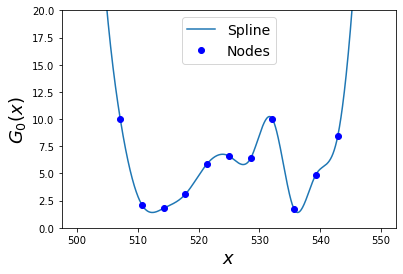

In [93]:
plt.plot(x_axis, true_y, label='Spline')
plt.plot(x_knots, y_knots, 'ob', label='Nodes')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$G_0(x)$', fontsize=18)
plt.legend(fontsize=14)
plt.ylim(0, 20)

In [94]:
T = 2000000
dt = 0.1 # \mu s
N = round(T / dt)
saving_freq = 10
Dx = 0.38 # nm^2 / \mu s
Dq = Dx
k = 0.08
print(N, N//saving_freq, Dx*dt)

20000000 2000000 0.038000000000000006


In [ ]:
T = 500000
dt = 5e-4
N = int(T / dt)
saving_freq = 100
Dx = 1
Dq = 1
k = 1
print(N, N//saving_freq, Dx*dt)

In [103]:
q = brownian_integrator(x0=520., q0=520., Dx=Dx, Dq=Dq, x_knots=x_knots, y_knots=y_knots, k=k, N=N, dt=dt, fs=saving_freq)

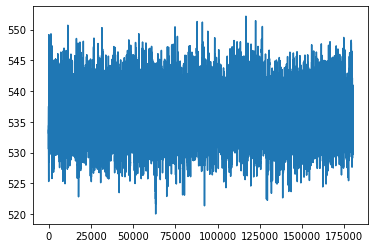

In [107]:
plt.plot(q[20000:200000])

In [97]:
import statsmodels.tsa.stattools as stat_tools
import scipy as scp
import bottleneck as bn

In [108]:
acf = stat_tools.acf(q[20000:200000], nlags=200, fft=True)
x = np.arange(0, len(acf), 1)

exp_func = lambda t, a: np.exp(-(1/a)*t)
params, _ = scp.optimize.curve_fit(exp_func,  x,  acf)

print((q ** 2).mean()/params[0])

8071.788832657138


In [68]:
print(q.min(), q.max())

499.2297243498635 548.6556393238649


In [69]:
np.std(q[1:] - q[:-1])

0.8665663439472945

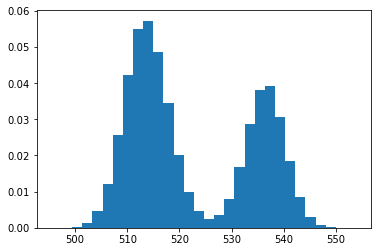

In [30]:
counts, bins, _ = plt.hist(q, bins=30, density=True)

Text(0.5, 1.0, 'log(Dq/Dx) = 0.0, k = 0.08')

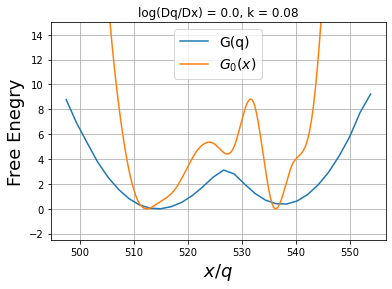

In [35]:
plt.plot(bins[1:], -np.log(counts) - np.min(-np.log(counts)), label='G(q)')
plt.plot(x_axis, true_y - np.min(true_y), label=r'$G_0(x)$')
plt.ylim(-2.5, 15)
plt.xlabel(r'$x/q$', fontsize=18)
plt.ylabel(r'Free Enegry', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.title(f'log(Dq/Dx) = {np.log10(Dq/Dx)}, k = {k}')

In [ ]:
plt.plot(q)

In [ ]:
np.save('test_trajectory.npy', q)